In [1]:
import sys
sys.path.append(r'/home/martinha/propythia/propythia/src/propythia/')
sys.path.append(r'/home/martinha/propythia/propythia/src/')

# ProPythia DNA and ML

This is a notebook that explains how to perform every step of the developed Machine Learning modules. They include all the necessary steps to calculate descriptors that will serve as features for the model. The model building and prediction steps were already implemented in ProPythia but will be included as well in this notebook to prove that the calculated features can be used. 

The steps included in this notebook are:

1. Data reading and validation
2. Calculation of descriptors from sequences
3. Descriptors processing
4. Using processed descriptors to train ML models (already implemented in ProPythia)



All the DNA notebooks will use the dataset from the tutorial linked to the manuscript, A Primer on Deep Learning in Genomics (Nature Genetics, 2018) by James Zou, Mikael Huss, Abubakar Abid, Pejman Mohammadi, Ali Torkamani & Amalio Telentil.

In [2]:
%load_ext autoreload
%autoreload 2

import json
import sys
sys.path.append("../")

## 1. Data reading and validation

(The deep learning pipeline uses the same module to read and validate the sequences.)

This module comprehends functions to read and to validate DNA sequences. First is necessary to create the object ReadDNA.

In [3]:
from propythia.dna.sequence import ReadDNA
reader = ReadDNA()

It is possible to create sequence objects using a single DNA sequence, a *CSV* and a *FASTA* file. The single sequence is going to be validated (check if all letters belong to the DNA alphabet) and the output will be the sequence in upper case.

In [4]:
data = reader.read_sequence("ACGTACGAGCATGCAT")
print(data)

ACGTACGAGCATGCAT


With *CSV* there must be at least a column named 'sequence' in the file. The labels may also be retrieved and validated if the user wants them, but he must specify the `with_label` parameter as **True** and the column with the labels must be named 'label'.

In [5]:
filename = "./primer/dataset.csv"
data = reader.read_csv(filename, with_labels=False)
print(data.head())
print(data.shape)

print("-" * 100)

data = reader.read_csv(filename, with_labels=True)
print(data.head())
print(data.shape)

                                            sequence
0  CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
1  GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
2  GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
3  GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
4  GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...
(2000, 1)
----------------------------------------------------------------------------------------------------
                                            sequence  label
0  CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...      0
1  GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...      0
2  GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...      0
3  GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...      1
4  GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...      1
(2000, 2)


The *FASTA* format is similar to the *CSV* format. It always reads the sequence, and the labels only if the user wants them. The *FASTA* format must be one of the following examples:

```
>sequence_id1
ACTGACTGACTGACTGACTGACTGACTGACTGACTGACTG...
>sequence_id2
ACTGACTGACTGACTGACTGACTGACTGACTGACTGACTG...
``` 

```
>sequence_id1,label1
ACTGACTGACTGACTGACTGACTGACTGACTGACTGACTG...
>sequence_id2,label2
ACTGACTGACTGACTGACTGACTGACTGACTGACTGACTG...
``` 

In [6]:
filename = "./primer/example.fasta"
data = reader.read_fasta(filename, with_labels=False)
print(data.head())
print(data.shape)

print("-" * 100)

data = reader.read_fasta(filename, with_labels=True)
print(data.head())
print(data.shape)

                                            sequence
0  CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
1  GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
2  GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
3  GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
4  GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...
(19, 1)
----------------------------------------------------------------------------------------------------
                                            sequence  label
0  CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...      0
1  GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...      0
2  GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...      0
3  GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...      1
4  GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...      1
(19, 2)


## 2. Calculation of descriptors from sequences

This module comprehends functions to computing different types of DNA descriptors. It receives a sequence object (from previous module) and retrieves a dictionary with name of feature and value. The user can calculate individual descriptors and also calculate all descriptors. It also lets the users to use define the physicochemical indices for the autocorrelation descriptors if the user doesn't want to use the default values or if he wants to add new ones. 



There are a total of 17 DNA implemented descriptors. They can be found below:

<table>
<thead>
  <tr>
    <th>Group</th>
    <th>Name</th>
    <th>Output type</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td rowspan="3">Psycho Chemical</td>
    <td>length</td>
    <td>int</td>
  </tr>
  <tr>
    <td>gc_content</td>
    <td>float</td>
  </tr>
  <tr>
    <td>at_content</td>
    <td>float</td>
  </tr>
  <tr>
    <td rowspan="6">Nucleic Acid Composition</td>
    <td>nucleic_acid_composition</td>
    <td>dict</td>
  </tr>
  <tr>
    <td>dinucleotide_composition</td>
    <td>dict</td>
  </tr>
  <tr>
    <td>trinucleotide_composition</td>
    <td>dict</td>
  </tr>
  <tr>
    <td>k_spaced_nucleic_acid_pairs</td>
    <td>dict</td>
  </tr>
  <tr>
    <td>kmer</td>
    <td>dict</td>
  </tr>
  <tr>
    <td>accumulated_nucleotide_frequency</td>
    <td>list of dict</td>
  </tr>
  <tr>
    <td rowspan="6">Autocorrelation and Cross Covariance</td>
    <td>DAC</td>
    <td>list</td>
  </tr>
  <tr>
    <td>DCC</td>
    <td>list</td>
  </tr>
  <tr>
    <td>DACC</td>
    <td>list</td>
  </tr>
  <tr>
    <td>TAC</td>
    <td>list</td>
  </tr>
  <tr>
    <td>TCC</td>
    <td>list</td>
  </tr>
  <tr>
    <td>TACC</td>
    <td>list</td>
  </tr>
  <tr>
    <td rowspan="2">Pseudo Nucleic Acid Composition</td>
    <td>PseDNC</td>
    <td>dict</td>
  </tr>
  <tr>
    <td>PseKNC</td>
    <td>dict</td>
  </tr>
</tbody>
</table>

As mentioned above, the user can calculate all descriptors or individual descriptors. To calculate individual descriptors, the user must specify the name/names of the descriptor/descriptors in the `descriptor_list` parameter. If this parameter is not specified, the user will calculate all descriptors.

To calculate a single descriptor, called 'nucleic_acid_composition', for a single sequence, the user must do:

In [7]:
reader = ReadDNA()
data = reader.read_sequence("ACGTACGAGCATGCAT")

from propythia.dna.descriptors import DNADescriptor
calculator = DNADescriptor(data)

descriptor_list = ['nucleic_acid_composition']
result = calculator.get_descriptors(descriptor_list)
print(json.dumps(result, indent=4))

{
    "nucleic_acid_composition": {
        "A": 0.312,
        "C": 0.25,
        "G": 0.25,
        "T": 0.188
    }
}


To calculate all of them, the user must leave the `descriptor_list` parameter empty.

In [8]:
descriptor_list = []
result = calculator.get_descriptors(descriptor_list)
for key, val in result.items():
    print(key, val)
    print("-" * 100)

length 16
----------------------------------------------------------------------------------------------------
gc_content 0.5
----------------------------------------------------------------------------------------------------
at_content 0.5
----------------------------------------------------------------------------------------------------
nucleic_acid_composition {'A': 0.312, 'C': 0.25, 'G': 0.25, 'T': 0.188}
----------------------------------------------------------------------------------------------------
dinucleotide_composition {'AA': 0.0, 'AC': 0.133, 'AG': 0.067, 'AT': 0.133, 'CA': 0.133, 'CC': 0.0, 'CG': 0.133, 'CT': 0.0, 'GA': 0.067, 'GC': 0.133, 'GG': 0.0, 'GT': 0.067, 'TA': 0.067, 'TC': 0.0, 'TG': 0.067, 'TT': 0.0}
----------------------------------------------------------------------------------------------------
trinucleotide_composition {'AAA': 0.0, 'AAC': 0.0, 'AAG': 0.0, 'AAT': 0.0, 'ACA': 0.0, 'ACC': 0.0, 'ACG': 0.143, 'ACT': 0.0, 'AGA': 0.0, 'AGC': 0.071, 'AGG': 0.0

It is also possible to calculate the descriptors for the *CSV* and the *FASTA* files, which contains a list of sequences.

In [9]:
reader = ReadDNA()
filename = './primer/dataset.csv'
data = reader.read_csv(filename=filename, with_labels=True)

# get the sequences from the dataframe
sequences = data['sequence'].to_list()

# specify the descriptor list
descriptor_list = ['nucleic_acid_composition']

# only for the first 10 sequences
for i in range(10):
    sequence = sequences[i]
    calculator = DNADescriptor(sequence)
    
    print(sequence)
    print(calculator.get_descriptors(descriptor_list))
    print("-" * 100)

CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC
{'nucleic_acid_composition': {'A': 0.18, 'C': 0.26, 'G': 0.34, 'T': 0.22}}
----------------------------------------------------------------------------------------------------
GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGCGTCG
{'nucleic_acid_composition': {'A': 0.12, 'C': 0.16, 'G': 0.32, 'T': 0.4}}
----------------------------------------------------------------------------------------------------
GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTAGCCT
{'nucleic_acid_composition': {'A': 0.34, 'C': 0.26, 'G': 0.28, 'T': 0.12}}
----------------------------------------------------------------------------------------------------
GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGCCCTG
{'nucleic_acid_composition': {'A': 0.24, 'C': 0.42, 'G': 0.22, 'T': 0.12}}
----------------------------------------------------------------------------------------------------
GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATATGGT
{'nucleic_acid_composition': {'A': 0.28, '

## 3. Descriptors processing

So far we have seen how to read and validate DNA sequences. We've also seen how to calculate descriptors from a single sequence or multiple sequences. Now, we can use the descriptors to train a model.

However, as seen above, when calculating the descriptors for multiple sequences, the result is a list of dictionaries and each dictionary holds the calculated descriptors for a single sequence. So, the next step is to convert this data structure to a dataframe.

We can directly convert the list of dictionaries to a dataframe using the `pd.DataFrame()` function. The result of this step would be similar to the following:

(considering only the first few columns)

| sequence | length | gc_content | at_content | nucleic_acid_composition                         | ...
|----------|--------|------------|------------|--------------------------------------------------|---
| ACTGCGAT | 8      | 0.5        | 0.5        | {'A': 0.25, 'C': 0.25, 'T': 0.25, 'G': 0.25}     | ...
| TTGTTACT | 8      | 0.25       | 0.75       | {'A': 0.125, 'C': 0.125, 'T': 0.125, 'G': 0.625} | ...
| ...      | ...    | ...        | ...        | ...                                              | ...

As we can see, some of the descriptors are not numerical values (e.g. 'nucleic_acid_composition'). Descriptors that produce dictionaries or lists still need be normalized because the model cannot process data in those forms.

To normalize the data, dicts and lists need to "explode" into more columns. 

E.g. dicts:

| descriptor_hello |
| ---------------- |
| {'a': 1, 'b': 2} |

will be transformed into:

| descriptor_hello_a | descriptor_hello_b |
| ------------------ | ------------------ |
| 1                  | 2                  |

E.g. lists:

| descriptor_hello |
| ---------------- |
| [1, 2, 3]        |

will be transformed into:

| descriptor_hello_0 | descriptor_hello_1 | descriptor_hello_2 |
| ------------------ | ------------------ | ------------------ |
| 1                  | 2                  | 3                  |

The `calculate_and_normalize` function will be used to calculate the descriptors and normalize them. It can be found in the `calculate_features.py` file.

In [10]:
reader = ReadDNA()
filename = './primer/dataset.csv'
data = reader.read_csv(filename=filename, with_labels=True)

# specify the descriptor list
descriptor_list = []

from propythia.dna.calculate_features import calculate_and_normalize
fps_x, fps_y = calculate_and_normalize(data)

fps_x

0 / 2000
100 / 2000
200 / 2000
300 / 2000
400 / 2000
500 / 2000
600 / 2000
700 / 2000
800 / 2000
900 / 2000
1000 / 2000
1100 / 2000
1200 / 2000
1300 / 2000
1400 / 2000
1500 / 2000
1600 / 2000
1700 / 2000
1800 / 2000
1900 / 2000
Done!


,length,gc_content,at_content,nucleic_acid_composition_A,nucleic_acid_composition_C,nucleic_acid_composition_G,nucleic_acid_composition_T,dinucleotide_composition_AA,dinucleotide_composition_AC,dinucleotide_composition_AG,...,accumulated_nucleotide_frequency_0_G,accumulated_nucleotide_frequency_0_T,accumulated_nucleotide_frequency_1_A,accumulated_nucleotide_frequency_1_C,accumulated_nucleotide_frequency_1_G,accumulated_nucleotide_frequency_1_T,accumulated_nucleotide_frequency_2_A,accumulated_nucleotide_frequency_2_C,accumulated_nucleotide_frequency_2_G,accumulated_nucleotide_frequency_2_T
0,50,0.60,0.40,0.18,0.26,0.34,0.22,0.041,0.061,0.061,...,0.462,0.154,0.20,0.12,0.40,0.28,0.184,0.184,0.368,0.263
1,50,0.48,0.52,0.12,0.16,0.32,0.40,0.000,0.020,0.061,...,0.308,0.385,0.20,0.16,0.36,0.28,0.158,0.132,0.316,0.395
2,50,0.54,0.46,0.34,0.26,0.28,0.12,0.082,0.061,0.163,...,0.385,0.154,0.44,0.12,0.36,0.08,0.368,0.263,0.263,0.105
3,50,0.64,0.36,0.24,0.42,0.22,0.12,0.020,0.143,0.082,...,0.231,0.077,0.24,0.44,0.16,0.16,0.237,0.421,0.211,0.132
4,50,0.54,0.46,0.28,0.26,0.28,0.18,0.082,0.102,0.041,...,0.308,0.077,0.32,0.36,0.20,0.12,0.289,0.342,0.211,0.158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,50,0.66,0.34,0.16,0.26,0.40,0.18,0.000,0.020,0.082,...,0.538,0.154,0.12,0.20,0.52,0.16,0.184,0.211,0.421,0.184
1996,50,0.44,0.56,0.22,0.22,0.22,0.34,0.041,0.061,0.041,...,0.308,0.308,0.20,0.12,0.28,0.40,0.237,0.211,0.263,0.289
1997,50,0.46,0.54,0.18,0.24,0.22,0.36,0.020,0.061,0.041,...,0.154,0.231,0.16,0.36,0.16,0.32,0.132,0.263,0.211,0.395
1998,50,0.48,0.52,0.28,0.24,0.24,0.24,0.102,0.061,0.041,...,0.462,0.077,0.24,0.32,0.28,0.16,0.237,0.289,0.289,0.184


The obtained dataframe contains all calculated descriptors for the input dataset. As we can see by the dataframe shape, it now contains 247 columns instead of just 17. This is because the descriptors are now normalized and the data is finally ready to be used by the model. It is also important to note that, regardless of the size of the sequences, the final dataframe will always have the same number of columns since the implemented descriptors produce always the same number of values.

## 4. Using processed descriptors to train a model

We've reached the ending point of this tutorial, as everything from now on was already implemented in ProPythia. The next steps will be shown either way to validate the calculated DNA descriptors.


The following tasks are the training of the model, obtaining the predictions and then the calculation of feature importance for Random Forest, Support Vector Machine and Linear SVM models.

In [11]:
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from propythia.ml.shallow_ml import ShallowML

/home/martinha/miniconda3/envs/propythia/lib/python3.9/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(
2023-08-14 10:02:17.015801: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Splitting the data and standard scaler the descriptors.

Find the best RF model with an hyperparameter search

In [12]:
# fps_x and fps_y are the features and labels calculated from the data in the previous chapter
X_train, X_test, y_train, y_test = train_test_split(fps_x, fps_y, stratify=fps_y)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

ml = ShallowML(X_train, X_test, y_train, y_test, report_name=None, columns_names=fps_x.columns)

param_grid = [{'clf__n_estimators': [100, 250, 500, 750], 'clf__max_features': ['sqrt']}]

best_rf_model = ml.train_best_model(
    model='rf',
    score=make_scorer(matthews_corrcoef),
    param_grid=param_grid,
    cv=10
)

performing gridSearch...
GridSearchCV took 11.09 seconds for 4 candidate parameter settings.
GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf',
                                        RandomForestClassifier(random_state=1))]),
             n_jobs=5,
             param_grid=[{'clf__max_features': ['sqrt'],
                          'clf__n_estimators': [100, 250, 500, 750]}],
             scoring=make_scorer(matthews_corrcoef))
Model with rank: 1
 Mean validation score: 0.992 (std: 0.011)
 Parameters: {'clf__max_features': 'sqrt', 'clf__n_estimators': 250}
 

Model with rank: 2
 Mean validation score: 0.991 (std: 0.010)
 Parameters: {'clf__max_features': 'sqrt', 'clf__n_estimators': 500}
 

Model with rank: 2
 Mean validation score: 0.991 (std: 0.010)
 Parameters: {'clf__max_features': 'sqrt', 'clf__n_estimators': 750}
 

make_scorer(matthews_corrcoef)
10
Best score (scorer: make_scorer(matthews_corrcoef)) and paramet

calculate scores on the test set

In [13]:
scores, report, cm, cm2 = ml.score_testset(best_rf_model)
print(report)
print(cm)  
scores

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       253
           1       1.00      1.00      1.00       247

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500

[[252   1]
 [  0 247]]


{'Accuracy': 0.998,
 'MCC': 0.9960075855857898,
 'log_loss': 0.050448022905071215,
 'f1 score': 0.997979797979798,
 'roc_auc': 0.9980237154150198,
 'Precision': array([0.494     , 0.99596774, 1.        ]),
 'Recall': array([1., 1., 0.]),
 'fdr': 0.004032258064516129,
 'sn': 1.0,
 'sp': 0.9960474308300395}

Get the most important features 

In [22]:
ml.features_importances_df(
    classifier=best_rf_model, 
    top_features=10)


,importance
trinucleotide_composition_CGA,0.141909
PseKNC_CGA,0.129935
PseKNC_ACT,0.043692
PseKNC_CCG,0.041638
trinucleotide_composition_CCG,0.039442
...,...
trinucleotide_composition_TGG,0.000062
trinucleotide_composition_TTA,0.000050
trinucleotide_composition_TGT,0.000041
trinucleotide_composition_AGC,0.000040


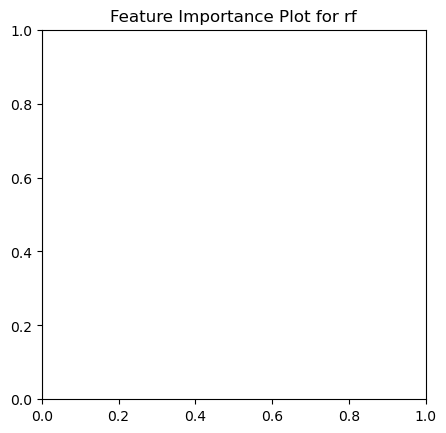

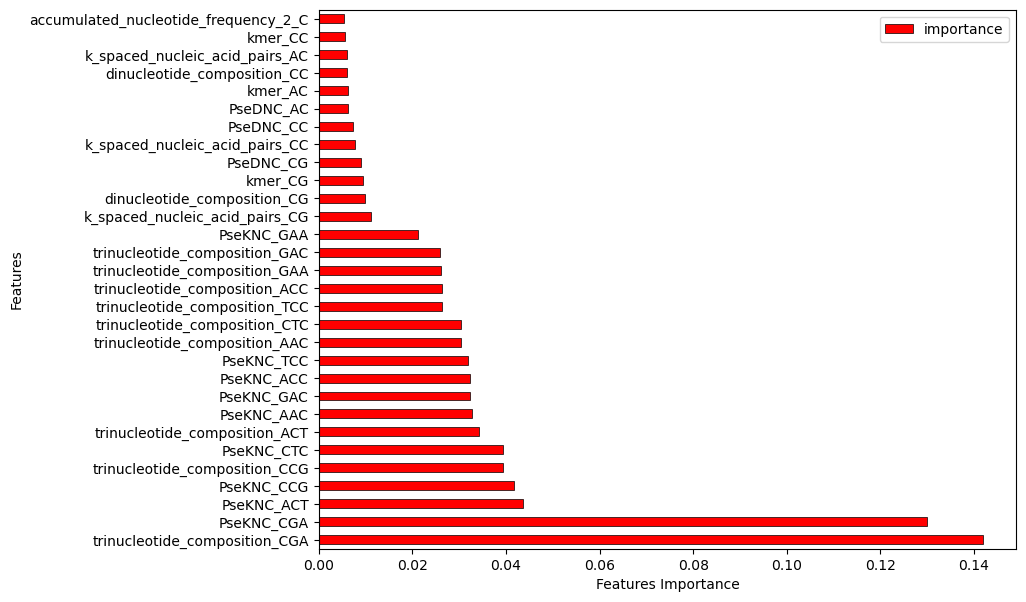

<Figure size 640x480 with 0 Axes>

In [14]:
ml.features_importances_plot(
    classifier=best_rf_model, 
    top_features=30, 
    model_name='rf',
    show=True, 
    path_save=None
)

Let's try now using SVM.

In [15]:
ml = ShallowML(X_train, X_test, y_train, y_test, report_name=None, columns_names=fps_x.columns)

param_grid = {'clf__C':[10], 'clf__gamma':[0.001], 'clf__kernel':['rbf']}

best_svm_model = ml.train_best_model(
    model='svc',
    score=make_scorer(matthews_corrcoef),
    param_grid=param_grid,
)

performing gridSearch...
GridSearchCV took 0.30 seconds for 1 candidate parameter settings.
GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf', SVC(random_state=1))]),
             n_jobs=5,
             param_grid={'clf__C': [10], 'clf__gamma': [0.001],
                         'clf__kernel': ['rbf']},
             scoring=make_scorer(matthews_corrcoef))
Model with rank: 1
 Mean validation score: 0.946 (std: 0.036)
 Parameters: {'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
 

make_scorer(matthews_corrcoef)
10
Best score (scorer: make_scorer(matthews_corrcoef)) and parameters from a 10-fold cross validation:
 MCC score:	0.946
 Parameters:	{'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}

0.946067 (0.035968) with: {'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
   clf__C  clf__gamma clf__kernel     means      stds
0      10       0.001         rbf  0.946067  0.035968


In [16]:
scores, report, cm, cm2 = ml.score_testset(best_svm_model)
print(report)
print(cm)  
scores

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       253
           1       0.95      0.97      0.96       247

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500

[[241  12]
 [  7 240]]


{'Accuracy': 0.962,
 'MCC': 0.9241921167195694,
 'f1 score': 0.9619238476953906,
 'roc_auc': 0.9621145444944071,
 'Precision': array([0.494     , 0.95238095, 1.        ]),
 'Recall': array([1.        , 0.97165992, 0.        ]),
 'fdr': 0.047619047619047616,
 'sn': 0.97165991902834,
 'sp': 0.9525691699604744}

The SVM feature importance can only be calculated if the best model has a linear kernel. 

Since the best model has the RBF kernel, we can't calculate the feature importance, so we will use the linear_svc model instead.

If a parameter grid is not defined for the train best model, a default one will be used

In [17]:
ml = ShallowML(X_train, X_test, y_train, y_test, report_name=None, columns_names=fps_x.columns)

best_linear_svm_model = ml.train_best_model(
    model='linear_svc',                               
    score=make_scorer(matthews_corrcoef),
    param_grid=None
)

performing gridSearch...


/home/martinha/miniconda3/envs/propythia/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/martinha/miniconda3/envs/propythia/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/martinha/miniconda3/envs/propythia/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/martinha/miniconda3/envs/propythia/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/martinha/miniconda3/envs/propythia/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mart

GridSearchCV took 0.72 seconds for 4 candidate parameter settings.
GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf', LinearSVC(random_state=1))]),
             n_jobs=5, param_grid=[{'clf__C': [0.01, 0.1, 1.0, 10]}],
             scoring=make_scorer(matthews_corrcoef))
Model with rank: 1
 Mean validation score: 0.926 (std: 0.041)
 Parameters: {'clf__C': 0.1}
 

Model with rank: 2
 Mean validation score: 0.925 (std: 0.037)
 Parameters: {'clf__C': 0.01}
 

Model with rank: 3
 Mean validation score: 0.905 (std: 0.039)
 Parameters: {'clf__C': 1.0}
 

make_scorer(matthews_corrcoef)
10
Best score (scorer: make_scorer(matthews_corrcoef)) and parameters from a 10-fold cross validation:
 MCC score:	0.926
 Parameters:	{'clf__C': 0.1}

0.924640 (0.037453) with: {'clf__C': 0.01}
0.925805 (0.041192) with: {'clf__C': 0.1}
0.904630 (0.039276) with: {'clf__C': 1.0}
0.886002 (0.037604) with: {'clf__C': 10}
   clf__C     means      s

In [18]:
scores, report, cm, cm2 = ml.score_testset(best_linear_svm_model)
print(report)
print(cm)  
scores

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       253
           1       0.95      0.95      0.95       247

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500

[[241  12]
 [ 12 235]]


{'Accuracy': 0.952,
 'MCC': 0.9039861740090573,
 'f1 score': 0.951417004048583,
 'roc_auc': 0.9519930870045287,
 'Precision': array([0.494   , 0.951417, 1.      ]),
 'Recall': array([1.      , 0.951417, 0.      ]),
 'fdr': 0.048582995951417005,
 'sn': 0.951417004048583,
 'sp': 0.9525691699604744}

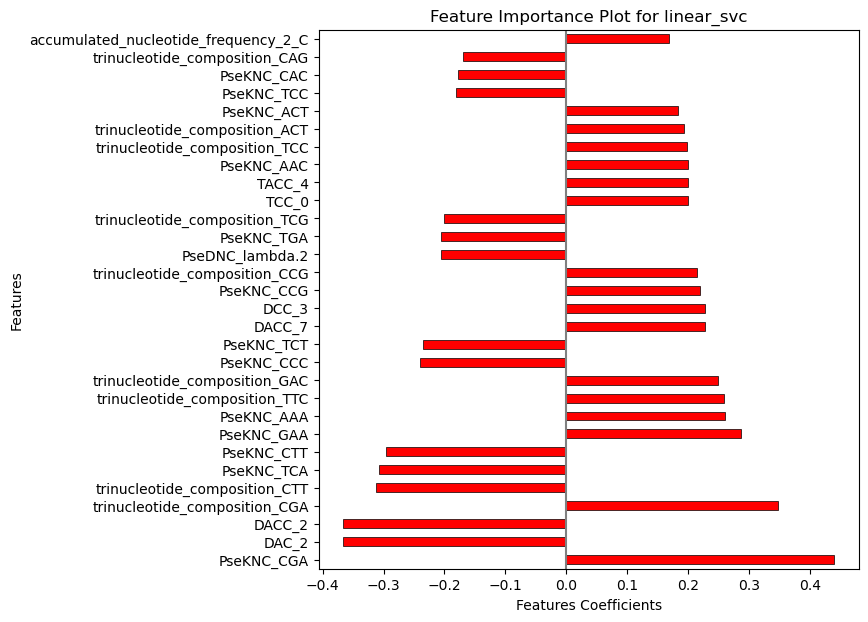

<Figure size 640x480 with 0 Axes>

In [19]:
ml.features_importances_plot(
    classifier=best_linear_svm_model, 
    model_name='linear_svc',
    column_to_plot=0,
    top_features=30, 
    show=True, 
    path_save=None
)

We've reached the end of the machine learning pipeline. As we could see, the implemented descriptors were used as features for all the models, obtaining great performances for all of them.